<a href="https://colab.research.google.com/github/MaxZx3000/AI-Compfest-GigaPrime/blob/master/artificial-intelligence/tourism_news_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tourism News AI

Library Import

In [12]:
! pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

google_url = "https://www.google.com/search?q=SampleStackOverflow"
google_url

'https://www.google.com/search?q=SampleStackOverflow'

Rqeuest Sample Data

'<!doctype html><html lang="en"><head><meta charset="UTF-8"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>SampleStackOverflow - Google Search</title><script nonce="6QJAzoQ2KxGdLfmOOJKvIg">(function(){\ndocument.documentElement.addEventListener("submit",function(b){var a;if(a=b.target){var c=a.getAttribute("data-submitfalse");a="1"===c||"q"===c&&!a.elements.q.value?!0:!1}else a=!1;a&&(b.preventDefault(),b.stopPropagation())},!0);document.documentElement.addEventListener("click",function(b){var a;a:{for(a=b.target;a&&a!==document.documentElement;a=a.parentElement)if("A"===a.tagName){a="1"===a.getAttribute("data-nohref");break a}a=!1}a&&b.preventDefault()},!0);}).call(this);(function(){\nvar a=window.performance;window.start=Date.now();a:{var b=window;if(a){var c=a.timing;if(c){var d=c.navigationStart,f=c.responseStart;if(f>d&&f<=window.start){window.start=f;b.wsrt=f-d;break a}}a.now&&(b.wsrt=Math.floor(a.now()))}}window.google=window
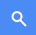
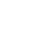
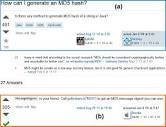
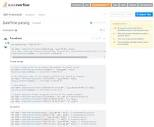

In [20]:
r = requests.get(google_url)
r.text

In [28]:
beautiful_soup = BeautifulSoup(r.text)

# for i in b:
for element in beautiful_soup.find_all('h3'):
  a_element = element.parent
  a_element.
  print(element.parent)

<a href="/url?q=https://stackoverflow.com/questions/1657484/can-you-give-an-example-of-stack-overflow-in-c&amp;sa=U&amp;ved=2ahUKEwjEsuaDh6X5AhW4RzABHeFsA0gQFnoECAIQAg&amp;usg=AOvVaw1aa3oVO7wccfiavnOySvXN"><h3 class="zBAuLc l97dzf"><div class="BNeawe vvjwJb AP7Wnd">Can you give an example of stack overflow in C++?</div></h3><div class="BNeawe UPmit AP7Wnd">stackoverflow.com › questions › can-you-give-an-example-of-stack-overfl...</div></a>
<a href="/url?q=https://stackoverflow.com/help/minimal-reproducible-example&amp;sa=U&amp;ved=2ahUKEwjEsuaDh6X5AhW4RzABHeFsA0gQFnoECAUQAg&amp;usg=AOvVaw1mkFdtCvDPKDCr8snrYr5e"><h3 class="zBAuLc l97dzf"><div class="BNeawe vvjwJb AP7Wnd">How to create a Minimal, Reproducible Example - Help Center</div></h3><div class="BNeawe UPmit AP7Wnd">stackoverflow.com › help › minimal-reproducible-example</div></a>
<a href="/url?q=https://www.kaggle.com/datasets/stackoverflow/stacksample&amp;sa=U&amp;ved=2ahUKEwjEsuaDh6X5AhW4RzABHeFsA0gQFnoECAEQAg&amp;usg=AOvVaw3HI